**Тестирование регрессионных моделей. Используемый датасет - Diabetes.**

**Назначение:**

Это регрессионный датасет, предназначенный для предсказания количественной меры прогрессирования заболевания диабетом через один год после исходного состояния.

Датасет содержит данные о 442 пациентах. Для каждого пациента записаны 10 базовых признаков и целевая переменная.

Датасет включает 10 числовых признаков:
*   age: возраст
*   sex: пол
*   bmi: индекс массы тела (body mass index)
*   bp: среднее кровяное давление
*   s1, s2, s3, s4, s5, s6: шесть измерений сыворотки крови (например, общий холестерин, ЛПНП, ЛПВП, холестерин, триглицериды, возможное содержание сахара - точные названия не всегда указываются в публичных версиях, но для модели это не так важно)

**Важная особенность признаков:**

В отличие от многих "сырых" датасетов, признаки в датасете Diabetes, доступном в scikit-learn, уже предобработаны: центрированы (имеют нулевое среднее),
масштабированы (шкалированы таким образом, что имеют примерно единичную дисперсию). Это означает, что не нужно выполнять StandardScaler для этого датасета.

**Целевая Переменная (Target):**

Целевая переменная — это количественная мера прогрессирования заболевания, числовое значение. Необходимо предсказать именно это значение.

In [2]:
# 1. Загрузим датасет и изучим его

# библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import load_diabetes

In [3]:
# Загрузка датасета Diabetes
diabetes = load_diabetes()
X_diabetes = diabetes.data  # Признаки
y_diabetes = diabetes.target  # Целевая переменная
feature_names_diabetes = diabetes.feature_names  # Названия признаков

print(f"Размер признаков (X): {X_diabetes.shape}")
print(f"Размер целевой переменной (y): {y_diabetes.shape}")
print(f"Названия признаков: {feature_names_diabetes}")

Размер признаков (X): (442, 10)
Размер целевой переменной (y): (442,)
Названия признаков: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']



Первые 5 строк DataFrame:
        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0  


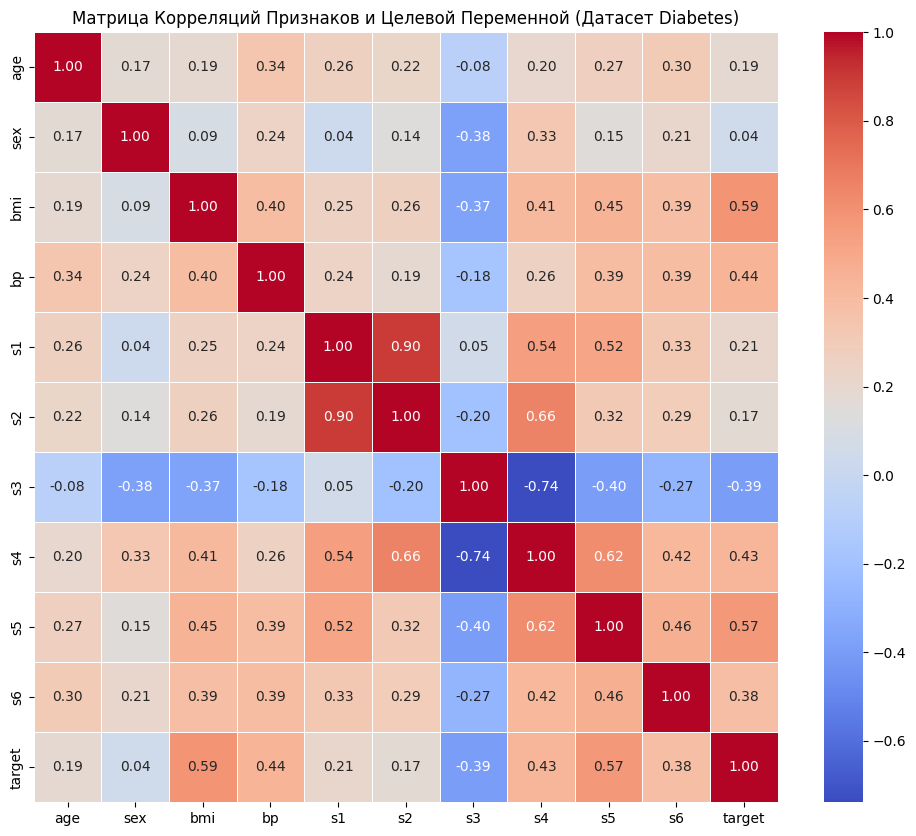

In [4]:
# Создаем DataFrame из признаков
df_diabetes = pd.DataFrame(X_diabetes, columns=feature_names_diabetes)

# Добавляем целевую переменную в DataFrame
df_diabetes['target'] = y_diabetes

print("\nПервые 5 строк DataFrame:")
print(df_diabetes.head())

# Рассчитываем матрицу попарных корреляций
correlation_matrix = df_diabetes.corr()

# Визуализация матрицы корреляций с помощью Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Матрица Корреляций Признаков и Целевой Переменной (Датасет Diabetes)')
plt.show()

In [4]:
# Обратим внимание на коррелляции параметров (s2 и s3 = 0.9), (s3 и s4 = -0.74)
# сначала будем моделировать с исходными данными, потом с обработанными и сравним

In [14]:
# 2. Моделирование

# библиотеки
from sklearn.model_selection import train_test_split, cross_val_score

# регрессионные модели
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# метрики
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [16]:
# Функция для расчета регрессионных метрик и возврата их в словаре
def get_regression_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {
        'MAE': round(mae, 3), # Округляем для читаемости
        'RMSE': round(rmse, 3),
        'R2': round(r2, 3)
    }

# Список моделей для тестирования
models_to_test = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.1, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
    "GBoosting": GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR(kernel='rbf', C=100, gamma=0.1)
}

In [17]:
# Определяем X (признаки) и y (целевая переменная) для разделения
X_df = df_diabetes.drop(columns=['target'])
y_series = df_diabetes['target']

# Разделяем полные признаки и целевую переменную на тренировочную и тестовую выборки
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_df, y_series, test_size=0.2, random_state=42
)

In [18]:
# Создаем DataFrame с обработанными признаками, удалив колонки 's2' и 's4' (из-за высокой корреляции) из тренировочной и тестовой выборок
features_to_drop = ['s2','s4'] # Список признаков для удаления
X_train_processed = X_train_full.drop(columns=features_to_drop)
X_test_processed = X_test_full.drop(columns=features_to_drop)

In [19]:
# Список для хранения результатов всех тестов
all_results = []

# Тестируем модели на исходных и обработанных данных
data_versions = {
    "Original data": (X_train_full, X_test_full),
    "Processed data": (X_train_processed, X_test_processed)
}

# y_train и y_test одинаковы для обоих наборов признаков
y_train_data = y_train
y_test_data = y_test


for data_name, (X_train, X_test) in data_versions.items():
    for model_name, model in models_to_test.items():
        # Обучение и предсказание
        model.fit(X_train, y_train_data)
        y_pred = model.predict(X_test)

        # Метрики
        metrics = get_regression_metrics(y_test_data, y_pred)

        # Сохраняем результаты
        result_entry = {'Data Version': data_name, 'Model': model_name}
        result_entry.update(metrics) # Добавляем метрики в словарь
        all_results.append(result_entry)

# Таблица результатов
results_df = pd.DataFrame(all_results)

# Сортируем по R2 - от лучшего к худшему
results_df = results_df.sort_values(by=['R2', 'Data Version'], ascending=[False, True])

print("\n--- Сводная Таблица Результатов ---")
print(results_df)


--- Сводная Таблица Результатов ---
      Data Version          Model     MAE    RMSE     R2
16  Processed data            KNN  41.265  52.839  0.473
2    Original data          Lasso  42.854  52.898  0.472
11  Processed data          Lasso  42.855  52.898  0.472
9   Processed data         Linear  42.890  53.469  0.460
5    Original data  Random Forest  43.562  53.680  0.456
14  Processed data  Random Forest  44.019  53.802  0.454
0    Original data         Linear  42.794  53.853  0.453
6    Original data      GBoosting  44.603  53.837  0.453
15  Processed data      GBoosting  44.504  54.622  0.437
7    Original data            KNN  42.771  54.946  0.430
1    Original data          Ridge  46.139  55.474  0.419
10  Processed data          Ridge  46.292  55.512  0.418
4    Original data  Decision Tree  45.937  59.380  0.334
8    Original data            SVR  52.214  61.517  0.286
13  Processed data  Decision Tree  49.599  61.971  0.275
17  Processed data            SVR  53.253  62.545  

In [10]:
# данные по целевой метке
df_diabetes['target'].describe()

,target
count,442.000000
mean,152.133484
std,77.093005
min,25.000000
25%,87.000000
50%,140.500000
75%,211.500000
max,346.000000


Выводы по полученному результату:

*   Целевая метка лежит в диапазоне от ~25 до ~346. Среднее значение около 152, а стандартное отклонение около 77. Лучшие МАЕ/RMSE из таблицы около 43/53, довольно существенная ошибка по сравнению с разбросом самих значений (стандартное отклонение ~77). Если бы MAE/RMSE были, скажем, 5-10, это было бы достаточно точное предсказание.
*   R2 (доля дисперсии целевой переменной, которую модель способна объяснить), макимальное значение = 0.47 т.е. модель может объяснить только 47% причин, почему прогрессирование диабета у разных пациентов отличается. Остальные 53% изменчивости остаются необъясненными. Чем ближе R2 к 1, тем лучше модель объясняет данные. Значение 0.47 говорит о том, что более половины факторов, влияющих на прогресс диабета, похоже отсутствуют в признаках датасета.
*   Удаление сильно коррелирующих параметров дает ощутимый прирост точности для KNN


Можно попробовать подбор гиперпараметров.


In [11]:
!pip install optuna

In [11]:
# будем исопльзовать optuna на моделях с лучшим результатом - KNN и Lasso
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

In [21]:
# Определение Целевой Функции для Optuna (для Lasso)
def objective_lasso_explicit(trial, X_train_data, y_train_data):
    # Предлагаем значение для гиперпараметра 'alpha' модели Lasso
    # alpha должно быть положительным. Часто используется логарифмическая шкала.
    alpha = trial.suggest_float('alpha', 1e-4, 1e0, log=True) # Пример диапазона для alpha

    # Создаем экземпляр модели Lasso с предложенным alpha
    # random_state для воспроизводимости при необходимости (хотя Lasso детерминирован с фиксированным alpha)
    model = Lasso(alpha=alpha, random_state=42, max_iter=10000) # Увеличим max_iter на всякий случай

    # Оцениваем модель с кросс-валидацией на тренировочных данных
    # Используем R2 как метрику для оптимизации (мы хотим ее максимизировать)
    # Или 'neg_mean_squared_error' (минимизировать)
    score = cross_val_score(
        model,
        X_train_data, # Тренировочные данные для кросс-валидации
        y_train_data,
        cv=5, # 5 фолдов кросс-валидации
        scoring='r2', # Метрика R2
        n_jobs=-1 # Использовать все ядра CPU
    )

    # Optuna по умолчанию минимизирует. Если мы оптимизируем R2 (максимизируем), нужно вернуть отрицательное значение среднего R2.
    return -score.mean() # Возвращаем отрицательное среднее значение R2

def objective_knn(trial, X_train_data, y_train_data):
    # Предлагаем значение для гиперпараметра 'n_neighbors' модели KNN
    n_neighbors = trial.suggest_int('n_neighbors', 2, 10)

    # Опционально: можно добавить другие параметры KNN для тюнинга
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 2) # 1 для Manhattan, 2 для Euclidean distance

    # Создаем экземпляр модели KNeighborsRegressor с предложенным n_neighbors
    model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=p, n_jobs=-1) # Если тюним доп. параметры
    #model = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=-1) # Если тюним только n_neighbors

    # Оцениваем Модель с Кросс-валидацией на тренировочных данных
    # Используем R2 как метрику для оптимизации (мы хотим ее максимизировать)
    score = cross_val_score(
        model,
        X_train_data, # Тренировочные данные для кросс-валидации
        y_train_data,
        cv=5, # 5 фолдов кросс-валидации
        scoring='r2', # Метрика R2
        n_jobs=-1 # Использовать все ядра CPU
    )

    # Optuna по умолчанию минимизирует. Возвращаем отрицательное среднее R2 для минимизации.
    return -score.mean()

X_train_for_optuna = X_train_processed
y_train_for_optuna = y_train
X_test_data_for_evaluation = X_test_processed
y_test_data_for_evaluation = y_test

# Создаем исследование Optuna для Lasso
study = optuna.create_study(direction='minimize', study_name="Lasso_Alpha_Optimization_Explicit")

# Запускаем процесс оптимизации
study.optimize(
    lambda trial: objective_lasso_explicit(
        trial,
        X_train_for_optuna,
        y_train_for_optuna
    ),
    n_trials=200 # Количество попыток
)
# Лучшая комбинация параметров
best_params_lasso = study.best_params
print(f"\nЛучшие параметры для Lasso, найденные Optuna: {best_params_lasso}")

# Лучшее значение метрики (отрицательный R2) по кросс-валидации
best_score_lasso_neg = study.best_value
print(f"Лучший результат (отрицательный R2) по кросс-валидации: {best_score_lasso_neg:.4f}")
print(f"Соответствующий R2 по кросс-валидации: {-best_score_lasso_neg:.4f}")

# Создаем финальную модель Lasso с лучшими найденными параметрами
final_lasso_model_tuned = Lasso(**study.best_params, random_state=42, max_iter=10000)

# Обучаем эту финальную модель на тренировочных данных, которые использовались для тюнинга
final_lasso_model_tuned.fit(X_train_for_optuna, y_train_for_optuna)

# Делаем предсказание
y_pred_tuned = final_lasso_model_tuned.predict(X_test_data_for_evaluation)

# Оцениваем финальную модель на тестовой выборке
final_metrics_lasso = get_regression_metrics(y_test_data_for_evaluation, y_pred_tuned)

print("Финальные метрики для настроенной Lasso на тестовой выборке:")
print(final_metrics_lasso)

[I 2025-04-30 12:36:14,258] A new study created in memory with name: Lasso_Alpha_Optimization_Explicit
[I 2025-04-30 12:36:16,701] Trial 0 finished with value: -0.4568613975065827 and parameters: {'alpha': 0.0015740649872380285}. Best is trial 0 with value: -0.4568613975065827.
[I 2025-04-30 12:36:16,780] Trial 1 finished with value: -0.4554950449023335 and parameters: {'alpha': 0.16722301942398882}. Best is trial 0 with value: -0.4568613975065827.
[I 2025-04-30 12:36:16,850] Trial 2 finished with value: -0.45865249553028653 and parameters: {'alpha': 0.1248411375428954}. Best is trial 2 with value: -0.45865249553028653.
[I 2025-04-30 12:36:16,910] Trial 3 finished with value: -0.4567605893559058 and parameters: {'alpha': 0.0001106562012596767}. Best is trial 2 with value: -0.45865249553028653.
[I 2025-04-30 12:36:16,960] Trial 4 finished with value: -0.45915121890174165 and parameters: {'alpha': 0.05989974409479193}. Best is trial 4 with value: -0.45915121890174165.
[I 2025-04-30 12:36


Лучшие параметры для Lasso, найденные Optuna: {'alpha': 0.08977477329358263}
Лучший результат (отрицательный R2) по кросс-валидации: -0.4594
Соответствующий R2 по кросс-валидации: 0.4594
Финальные метрики для настроенной Lasso на тестовой выборке:
{'MAE': 42.826, 'RMSE': np.float64(52.904), 'R2': 0.472}


In [25]:
# Создаем исследование Optuna для KNN
# direction='minimize', потому что objective_knn возвращает отрицательный R2
study = optuna.create_study(direction='minimize', study_name="KNN_n_neighbors_Optimization")

# Запускаем процесс оптимизации
# Используем лямбда-функцию для передачи тренировочных данных в целевую функцию objective_knn
study.optimize(
    lambda trial: objective_knn(
        trial,
        X_train_for_optuna,
        y_train_for_optuna
    ),
    n_trials=100 # Количество попыток (например, 100)
)

# Лучшая комбинация параметров
best_params_knn = study.best_params
print(f"\nЛучшие параметры для KNeighborsRegressor, найденные Optuna: {best_params_knn}")

# Лучшее значение метрики (отрицательный R2) по кросс-валидации
best_score_knn_neg = study.best_value
print(f"Лучший результат (отрицательный R2) по кросс-валидации: {best_score_knn_neg:.4f}")
print(f"Соответствующий R2 по кросс-валидации: {-best_score_knn_neg:.4f}")

# Создаем финальную модель KNeighborsRegressor с лучшими найденными параметрами
final_knn_model_tuned = KNeighborsRegressor(**study.best_params, n_jobs=-1) # Используем **study.best_params

# Обучаем эту финальную модель на тренировочных данных, которые использовались для тюнинга
final_knn_model_tuned.fit(X_train_for_optuna, y_train_for_optuna)

# Предсказание
y_pred_tuned = final_knn_model_tuned.predict(X_test_data_for_evaluation)

# Оцениваем финальную модель
final_metrics_knn = get_regression_metrics(y_test_data_for_evaluation, y_pred_tuned)

print("Финальные метрики для настроенного KNeighborsRegressor:")
print(final_metrics_knn)

# Визуализация результатов оптимизации
from optuna.visualization import plot_optimization_history, plot_param_importances
plot_param_importances(study).show()

[I 2025-04-30 12:49:16,782] A new study created in memory with name: KNN_n_neighbors_Optimization
[I 2025-04-30 12:49:19,071] Trial 0 finished with value: -0.30881323802123506 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: -0.30881323802123506.
[I 2025-04-30 12:49:19,151] Trial 1 finished with value: -0.38272553486715494 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: -0.38272553486715494.
[I 2025-04-30 12:49:19,222] Trial 2 finished with value: -0.34694808102590563 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: -0.38272553486715494.
[I 2025-04-30 12:49:19,300] Trial 3 finished with value: -0.2705643247722622 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: -0.38272553486715494.
[I 2025-04-30 12:49:19,380] Trial 4 finished with value: -0.39129289375444254 and parameters: {'n_neighbors': 10, 'weights':


Лучшие параметры для KNeighborsRegressor, найденные Optuna: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}
Лучший результат (отрицательный R2) по кросс-валидации: -0.3913
Соответствующий R2 по кросс-валидации: 0.3913
Финальные метрики для настроенного KNeighborsRegressor:
{'MAE': 40.181, 'RMSE': np.float64(50.194), 'R2': 0.524}


Лучший результат у KNN:
*   исходные данные R2 = 0.430, MAE = 42.771
*   без корреллирующих параметров R2 = 0.473, MAE = 41.265
*   подбор параметров с Optuna: R2: 0.524, MAE = 40.181
